In [1]:
#general settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pylab
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy import units as u
from astropy import constants as c
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy import optimize
#plt.rcParams['font.family']='FreeSerif'

# Pseudo Moist Adiabat

In [2]:
sigma=c.sigma_sb.value
R=c.R.value
gamma=1.4
Gamma_pd = (gamma - 1)/gamma
#Gamma_pd = R/cpd
c_pn = R/Gamma_pd #non condensable
c_pv = 4.0*R
Pbar = 101325.0 # 1 bar 
lmol=4.3655e4
p_0=1.4e11 #saturation pressure coefficient
p_n0=1*Pbar
kappa=0.01e0

In [3]:
# dry adiabat
def dryP(T,T0,P0,Gamma):
    P=P0*(T/T0)**(1.0/Gamma)
    return P

In [4]:
# pseudo moist adiabat dT/dP 
def pseudo_moist_adiabat(T,p):
    x_v = p_0*np.exp(-lmol/(R*T)) / p
    x_n = 1.0e0 - x_v
    
    k = ((R*T)/(p*c_pn)+(x_v*lmol)/(x_n*p*c_pn))/\
    (x_n+(x_v*c_pv/c_pn)+(x_v*lmol*lmol/(x_n*R*T*T*c_pn)))
    
    return k

## integration of pseudo moist adiabat

In [5]:
#q = -1 x pressure for adjust of ideint
def funcinv(T, q):
    return -pseudo_moist_adiabat(T,-q)

def getPT(t0,p_n0,p_top=10):
    p_s = (saturateP(t0)+p_n0) #Psurface
    p = -np.logspace(np.log10(p_s),np.log10(p_top),1000)
    t = odeint(funcinv, t0, p)
    return -p,t

## vapor pressure

In [6]:
def saturateP(T):
    return p_0*np.exp(-lmol/(R*T))

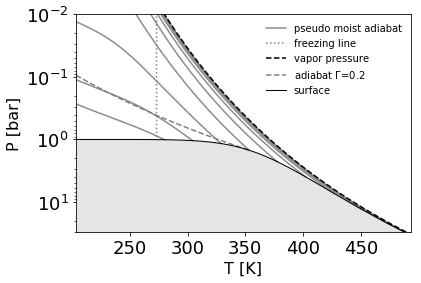

In [7]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.gca().invert_yaxis()
plt.yscale("log")
#plt.xscale("log")
t0list=np.linspace(280,500,10)
for t0 in t0list:
    p,t=getPT(t0,p_n0)
    if t0==t0list[0]:
        ax.plot(t,p/Pbar,c="gray",alpha=0.9,label="pseudo moist adiabat")
    else:
        ax.plot(t,p/Pbar,c="gray",alpha=0.9)
tlist=np.linspace(173.15,500,100)
plt.ylim(30,0.01)
plt.xlim(203.15,473+20.15)
ax.plot([273.15+0.01,273.15],[0.006,1],color="gray",ls="dotted",label="freezing line")
ax.plot(tlist,saturateP(tlist)/Pbar,color="black",ls="dashed",label="vapor pressure")

j=3
tlist=np.linspace(180,t0list[j],100)
ax.plot(tlist,dryP(tlist,t0list[j],(saturateP(t0list[j])+p_n0)/Pbar,0.2),c="gray",ls="dashed",label='adiabat $\Gamma$=0.2')
t0xlist=np.linspace(180,500,100)
plt.plot(t0xlist,(saturateP(t0xlist)+p_n0)/Pbar,color="black",lw=1,label="surface")
plt.fill_between(t0xlist,(saturateP(t0xlist)+p_n0)/Pbar,np.ones(len(t0xlist))*30.0,color="gray",alpha=0.2)

plt.tick_params(labelsize=18)
ax.legend(loc="upper right",prop={'size':10},frameon=False)
plt.ylabel("P [bar]",fontsize=16)
plt.xlabel("T [K]",fontsize=16)
plt.savefig("pseudomoist.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

# Radiative Convective Adjustment from the surface

In [8]:
#f = dtau/dp = (kappa_v*x_v + kappa_n*x_n)/g  
kappa_n = 0
kappa_v = 0.01
g=9.8 #gravity constant
D = 3.0/2.0 #diffusion coefficient
sigmaSB=5.670367*10**-8 #Stefan-Boltzman constant

## optical depth - pressure conversion function

In [9]:
def f(T,p):
    x_v = p_0*np.exp(-lmol/(R*T)) / p
    x_n = 1.0e0 - x_v
    return (kappa_v*x_v + kappa_n*x_n)/g 

## set interpolation function of T in the convective layer

In [10]:
#precompute of TP of pseudo adiabat
t0=300.0
p,t=getPT(t0,p_n0)
Tp = interp1d(p, t[:,0])

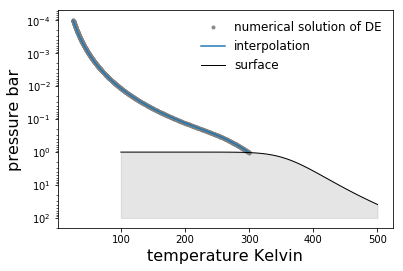

In [11]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.gca().invert_yaxis()
plt.yscale("log")
ax.plot(t,p/Pbar,".",c="gray",alpha=0.9,label="numerical solution of DE")
plist=np.linspace(0.0001,p_n0/Pbar,10000)*Pbar
ax.plot(Tp(plist),plist/Pbar,label="interpolation")
t0xlist=np.linspace(100,500,100)
plt.plot(t0xlist,(saturateP(t0xlist)+p_n0)/Pbar,color="black",lw=1,label="surface")
plt.fill_between(t0xlist,(saturateP(t0xlist)+p_n0)/Pbar,np.ones(len(t0xlist))*100.0,color="gray",alpha=0.2)
plt.ylabel("pressure bar",fontsize=16)
plt.xlabel("temperature Kelvin",fontsize=16)
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.show()

## integration of $F_+^{(c)}$

Solving 

$\frac{d}{d P}F_{+}^{(c)} (P) = f(P)  D [F_{+}^{(c)} (P)  - \sigma T^{(c) 4}(P)]$

$f(P) \equiv \frac{\kappa_v P_\mathrm{sat} (T^{(c)} (P))}{P g}$

by odeint.

In [12]:
def funcFinv(Fup,q):
    if q>0: return 0.0
    #print(q)
    T=Tp([-q])[0]
    sTf = sigmaSB*(T**4)
    return -f(T,-q)*D*(Fup - sTf)

def getFluxupper(T0in,p_top=5000):
    p_s = (saturateP(t0)+p_n0) #Psurface
    Fup0 = sigmaSB*T0in**4
    p = np.arange(-p_s,-p_top,1)
    Fup = odeint(funcFinv, Fup0, p)
    return -p,Fup.transpose()[0]


## upward flux of the radiation equilibrium at the RC boundary, $F_+^{(r)}$

$F_{+}^{(r)} (P_{rc})  =  \frac{D f(P) P + 2}{D f(P) P + 1} \sigma T^{(c) 4} (P_{rc})$

In [13]:
#assume constant mol fraction at stratosphere
def Fuprad(prc):
    Trc=Tp(prc)[0]
    taurc = f(Trc,prc)*prc
    Fup=(D*taurc + 2.0)/(D*taurc + 1.0)*sigmaSB*(Trc**4)
    return Fup[0]

## example for $T_s = 350$ K

In [14]:
t0=350.0
p_top=1
p,t=getPT(t0,p_n0,p_top*0.1)
print("prange",p[0],p[-1])
Tp = interp1d(p, t[:,0],fill_value="extrapolate")
print(Tp(104834.66184335788))
p,Fup=getFluxupper(t0,p_top)

prange 144091.234132 0.1
341.90050703699626


### get the intersection of $F_+^{(c)}$ and $F_+^{(r)}$

In [15]:
deltaF = interp1d(p,Fup-Fuprad([p]),fill_value="extrapolate")
Prc=(optimize.fsolve(deltaF,0.001*Pbar)/Pbar)[0]
Frc=Fuprad([Prc*Pbar])
Trc=Tp([Prc*Pbar])[0]
print(Fuprad([Prc*Pbar]),Prc)

309.689600241 0.0020134159025


/home/kawahara/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


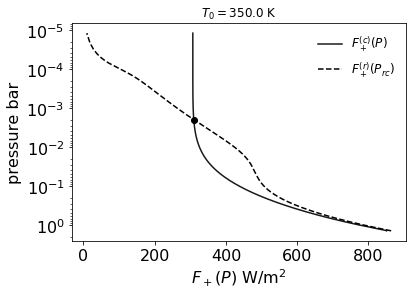

In [16]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.gca().invert_yaxis()
plt.yscale("log")
ax.plot(Fup,p/Pbar,c="black",alpha=0.9,label="$F_+^{(c)} (P)$")
ax.plot(Frc,Prc,"o",c="black")
#plt.title("$F_+(\\tau_{rc})=$"+str(round(Frc,1))+"$W/m^2$")
plist=np.linspace(0.1,1,100)*Pbar
ax.plot(Fuprad([p]),p/Pbar,label="$F_+^{(r)} (P_{rc})$",c="black",ls="dashed")
plt.ylabel("pressure bar",fontsize=16)
plt.tick_params(labelsize=16)
plt.title("$T_0=$"+str(t0)+" K")
plt.xlabel("$F_+(P)$ $\mathrm{W/m^2}$",fontsize=16)
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.savefig("Fadjust.pdf",bbox_inches="tight", pad_inches=0.1)
plt.show()

## Computing $F_+(P_{rc})$ as a function of T

In [17]:
t0listx=np.linspace(250,500,100)
Frcx=[]
Prcx=[]
Trcx=[]
initguess=0.001
#initguess=1.0
for t0 in t0listx:
    p_top=1
    p,t=getPT(t0,p_n0,p_top*0.1)
    Tp = interp1d(p, t[:,0],fill_value="extrapolate")
    p,Fup=getFluxupper(t0,p_top)
    deltaF = interp1d(p,Fup-Fuprad([p]),fill_value="extrapolate")
    Prc=(optimize.fsolve(deltaF,initguess*Pbar)/Pbar)[0]
    Frc=Fuprad([Prc*Pbar])
    Prcx.append(Prc)
    Frcx.append(Frc)
    Trcx.append(Tp([Prc*Pbar])[0])
Frcx=np.array(Frcx)
Prcx=np.array(Prcx)
Trcx=np.array(Trcx)

/home/kawahara/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## conversion to outward flux to space

In [18]:
taurcx = f(Trcx,Prc)*Prc
Foutx = 2/(D*taurcx + 2)*Frcx

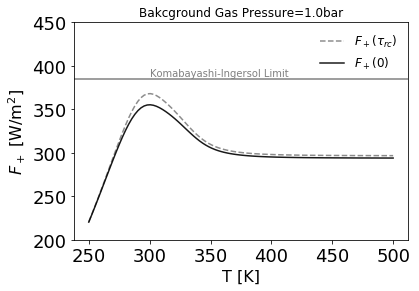

In [19]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(t0listx,Frcx,c="gray",alpha=0.9,ls="dashed",label="$F_+(\\tau_{rc})$")
ax.plot(t0listx,Foutx,c="black",alpha=0.9,label="$F_+(0)$")
plt.xlabel("T [K]",fontsize=16)
plt.ylabel("$F_+$ [$\mathrm{W/m^2}$]",fontsize=16)
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.tick_params(labelsize=18)
plt.axhline(385,color="gray")
plt.ylim(200,450)
ax.text(300,388,"Komabayashi-Ingersol Limit",color="gray")
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.title("Bakcground Gas Pressure="+str(round(p_n0/Pbar,0))+"bar")
plt.savefig("Fup.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

### radiation limit...

In [20]:
(Foutx[-1])

294.00856208743687

In [21]:
(Foutx[-1])*4/(1-0.3)/1370

1.2263130848276826

# different non-condensable gas pressures

In [22]:
p_n0list=[0.1*Pbar, Pbar, 10*Pbar,100*Pbar]

In [ ]:
# It takes time (several tens minutes) ...
Foutx=[]
for p_n0 in p_n0list:
    t0listx=np.linspace(250,500,100)
    Frcx=[]
    Prcx=[]
    Trcx=[]
    initguess=0.001
#initguess=1.0
    for t0 in t0listx:
        p_top=1
        p,t=getPT(t0,p_n0,p_top*0.1)
        Tp = interp1d(p, t[:,0],fill_value="extrapolate")
        p,Fup=getFluxupper(t0,p_top)
        deltaF = interp1d(p,Fup-Fuprad([p]),fill_value="extrapolate")
        Prc=(optimize.fsolve(deltaF,initguess*Pbar)/Pbar)[0]
        Frc=Fuprad([Prc*Pbar])
        Prcx.append(Prc)
        Frcx.append(Frc)
        Trcx.append(Tp([Prc*Pbar])[0])
    Frcx=np.array(Frcx)
    Prcx=np.array(Prcx)
    Trcx=np.array(Trcx)
    taurcx = f(Trcx,Prc)*Prc
    Foutx.append(2/(D*taurcx + 2)*Frcx)
    

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
lslist=["dotted","dashed","solid","dashdot"]
for i in range(0,len(p_n0list)):
    ax.plot(t0listx,Foutx[i],c="black",alpha=0.9,label=str(p_n0list[i]/Pbar)+" bar",ls=lslist[i])
plt.xlabel("T [K]",fontsize=16)
plt.ylabel("$F_+$ [$\mathrm{W/m^2}$]",fontsize=16)
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.tick_params(labelsize=18)
plt.axhline(385,color="gray")
plt.ylim(200,450)
ax.text(300,388,"Komabayashi-Ingersol Limit",color="gray")
ax.legend(loc="lower right",prop={'size':10},frameon=False)
plt.savefig("Fupn0.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

# Checking HZs (in the unit of solar flux)

In [1]:
(350)*4/(1-0.3)/1370

1.4598540145985404

In [2]:
(300)*4/(1-0.3)/1370

1.251303441084463

In [3]:
(388)*4/(1-0.3)/1370

1.618352450469239